# Introduction

This notebook demonstrates the application of [Grad-CAM](https://arxiv.org/abs/1610.02391) (Gradient-weighted Class Activation Mapping) on a deep neural network trained for Breast Imaging Reporting and Data System (BI-RADS) classification. BI-RADS is a standardized system used by radiologists to categorize findings in mammograms. In addition to classifying BI-RADS categories, we aim to visualize and localize areas within the mammogram that contribute most significantly to the network's decision-making process.

# Install dependencies



In [2]:
!pip install grad-cam
!pip install timm==0.8.11.dev0
!pip install qunet

import torch
from torch import nn
import cv2
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from timm.models import create_model
from qunet import Config
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Helper functions

## Transform

In [3]:
class ValTransform:

    def __init__(self, input_size, interpolation=cv2.INTER_LINEAR):
        self.input_size = input_size
        self.interpolation = interpolation
        self.max_h, self.max_w = input_size

        def _fit_resize(image, **kwargs):
            img_h, img_w = image.shape[:2]
            r = min(self.max_h / img_h, self.max_w / img_w)
            new_h, new_w = int(img_h * r), int(img_w * r)
            new_image = cv2.resize(image, (new_w, new_h),
                                   interpolation=interpolation)
            return new_image

        self.transform_fn = A.Compose([
            A.Lambda(name="FitResize",
                     image=_fit_resize,
                     always_apply=True,
                     p=1.0),
            A.PadIfNeeded(min_height=self.max_h,
                          min_width=self.max_w,
                          pad_height_divisor=None,
                          pad_width_divisor=None,
                          position=A.augmentations.geometric.transforms.PadIfNeeded.PositionType.CENTER,
                          border_mode=cv2.BORDER_CONSTANT,
                          value=0,
                          mask_value=None,
                          always_apply=True,
                          p=1.0),
            ToTensorV2(transpose_mask=True)
        ])

    def __call__(self, img):
        return self.transform_fn(image=img)['image']

## Reverse Transform

In [4]:
class ReverseValTransform:
    def __init__(self, input_size, interpolation=cv2.INTER_LINEAR):
        self.input_size = input_size
        self.interpolation = interpolation
        self.max_h, self.max_w = input_size


    def __call__(self, img, original_size):
        # Calculate padding that should be removed before resize
        img_h, img_w = original_size
        r = min(self.max_h / img_h, self.max_w / img_w)
        new_h, new_w = int(img_h * r), int(img_w * r)
        h_pad = (self.max_h - new_h)//2
        w_pad = (self.max_w - new_w)//2
        # Remove padding
        if len(img.shape) == 3:
          img = img[h_pad:self.max_h-h_pad, w_pad:self.max_w-w_pad, :]
        else:
          img = img[h_pad:self.max_h-h_pad, w_pad:self.max_w-w_pad]

        # Resize the image back
        img = cv2.resize(img, (img_w,img_h), interpolation=self.interpolation)

        return img

## Model

In [7]:
class ConvNext(nn.Module):
    def __init__(self, *arg, **kvargs):
        super().__init__()
        self.cfg = Config()
        cfg = self.cfg(*arg, **kvargs)

        self.convnext = create_model(**cfg.conv)


    def forward(self, x):
        x = self.convnext(x)
        return x


## Bounding Boxes

In [8]:
def get_bbox(cam, thresh=0.6):
  """Function generates bounding boxes from Class Activation Map"""

  max_value = cam.max()
  thresh = max_value * thresh
  seg = cv2.threshold(cam, thresh, 255, cv2.THRESH_BINARY)[1]
  connectivity = 4
  output = cv2.connectedComponentsWithStats(seg, connectivity, cv2.CV_32S)
  (num_labels, labels, stats, centroids) = output
  bbox = []
  for i in range(0, num_labels):
    # skipping 0 due to it outputs the background
    if i != 0:
        # identified dimensions unpacking
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        bbox.append([x, y, x + w, y + h])

  return bbox

def draw_boxes(boxes, image, color =(255, 0, 0)):
  """Function draws bounding boxes on image"""

  for i, box in enumerate(boxes):

        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 5
        )

  return image

# Configs



In [10]:
CFG = Config(
        model = Config(
             conv = {
             'model_name': 'convnext_small.fb_in22k_ft_in1k_384',
             'in_chans': 3,    # Image input channels
             'pretrained': False, # Start with pretrained version of specified network
             'num_classes': 5,    # Number of label classes
             'global_pool': 'max',    # Global pool type, one of (fast, avg, max, avgmax, avgmaxc)

             },

        ),

        input_size = (3, 1024, 768), # Input all image dimensions (d h w)
        mean=(0.25223466, 0.25223466, 0.25223466),
        std=(0.19936635, 0.19936635, 0.19936635),
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)

normalization_shape = (1, 3, 1, 1)
mean = torch.tensor(
            [x * 255 for x in CFG.mean], dtype=torch.float32).view(normalization_shape)
std = torch.tensor(
            [x * 255 for x in CFG.std], dtype=torch.float32).view(normalization_shape)

# Load Model

In [18]:
model = ConvNext(CFG.model)
fname = '/content/checkpoint.pt'
state = torch.load(fname, map_location='cpu')
model.load_state_dict(state['model'])
model.to(CFG.device).eval()

# Intialize GradCam

In [12]:
target_layers = [model.convnext.stages[3]]
cam = GradCAM(model=model, target_layers=target_layers)

transform = ValTransform(CFG.input_size[1:])
reverse_transform = ReverseValTransform(CFG.input_size[1:])

# Generate Activation Map

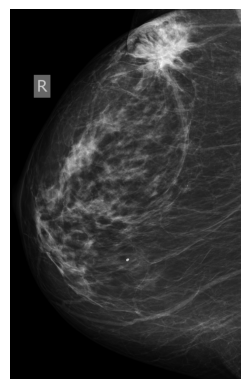

In [13]:
# read image
# Note: mammogram is already croped and converted to png
img_path = '/content/IMG-0003-00001.png'
image = cv2.imread(img_path)
img_shape = image.shape[:2]
plt.axis('off')
plt.imshow(image)

In [14]:
# preprocess image
image_tr = transform(image)
image_tr = (image_tr - mean) / std
image_tr = image_tr.to(CFG.device)

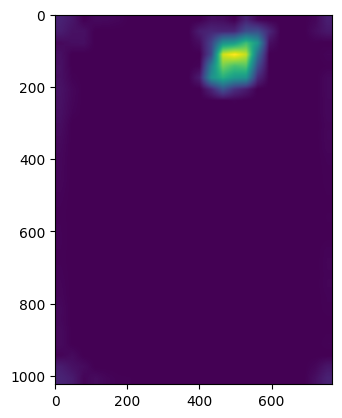

In [15]:
# get activation map
activation_map = cam(input_tensor=image_tr)
plt.imshow(activation_map.squeeze(0))

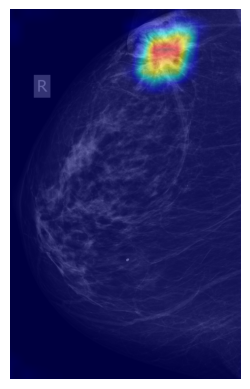

In [16]:
activation_map = reverse_transform(activation_map[0], img_shape)
visualization = show_cam_on_image(np.float32(image/255),activation_map, use_rgb=True)
plt.axis('off')
plt.imshow(visualization)

In [17]:
# find bboxes
cam_map = activation_map
cam_map = np.uint8(cam_map*255)
bbox = get_bbox(cam_map, thresh=0.1)
bbox

[[1179, 64, 1849, 794]]

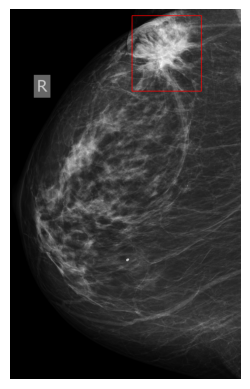

In [18]:
# draw bboxes
img = draw_boxes(bbox, image, color =(255, 0, 0))
plt.axis('off')
plt.imshow(img)